# Clustering for Hyperspectral Images  

In this notebook, we explore the use of unsupervised clustering methods to segment hyperspectral data into spatial regions with distinct spectral signatures. We begin with simple and well-known approaches such as K-means clustering. We consider  applying PCA beforehand, which already yields meaningful results in our dataset.

We then examine more complex methods such as DBSCAN and HDBSCAN, which are genrally used with a dimensionality reduction techniques like UMAP. 

We will use the same dataset as in Notebook 01, from 

> Torruella, P., Estrader, M., López-Ortega, A., Baró, M. D., Varela, M., Peiró, F., & Estradé, S. (2018). *Clustering analysis strategies for electron energy loss spectroscopy (EELS)*. Ultramicroscopy, 185, 42-48.

> Blanco-Portals, J., Peiró, F., & Estradé, S. (2022). *Strategies for EELS data analysis. Introducing UMAP and HDBSCAN for dimensionality reduction and clustering*. Microscopy and Microanalysis, 28(1), 109-122.



These combinations are common in the literature, where entire pipelines may involve a cascade of steps (e.g., PCA → UMAP → DBSCAN → SVM) to improve separation and classification.

However, these more sophisticated pipelines come with challenges: they introduce multiple hyperparameters and preprocessing decisions that can drastically affect the results. In practice, this makes them difficult to tune and validate, especially when no ground truth is available.

Our goal here is to provide a pedagogical overview of these methods, to highlight both their potential and limitations, and to reflect critically on the interpretability of clustering results in real scientific data.

⚙️ **Environment used:**  
- Python: 3.13.5
- NumPy: 2.2.6
- scikit-learn: 1.7.0
- matplotlib: 3.10.0
- umap-learn: 0.5.7
- hdbscan: 0.8.39

*hyperspy: not installed*

## 1. K-means  
K-means is a simple and widely used clustering algorithm that partitions the data into a fixed number of clusters, based on the assumption that each cluster is approximately spherical and equally sized. It works by iteratively assigning each point to the nearest cluster center and updating the centers as the mean of the assigned points.

K-means is fast and easy to use, but requires specifying the number of clusters in advance and can struggle with non-convex shapes or noisy data. In our case, it performs well after a linear dimensionality reduction by PCA.

In [1]:
import numpy as np # for data manipulation

import matplotlib.pyplot as plt # for visualization
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from umap import UMAP
import hdbscan

In [2]:
# for reproducibility
import random
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
# we will use the same set of data as for Notebook 1
# load data
HS_image_raw= np.load(r'C:\Users\brun\Documents\Donnees\AutumnSchool_AI_in_Electron_Microscopy2025\DataSets\Raw_MnOFeO_NP_coreLoss.npy')

In [4]:
# to check data's shape
print("Shape of the hyperspectral image:", HS_image_raw.shape)  # (n_lines, n_cols, n_bands)
n_lines, n_cols, n_bands_raw = HS_image_raw.shape

Shape of the hyperspectral image: (70, 100, 1730)


In [5]:
# we will flatten the data to have a (#pixels, #bands) shape
HS_image_flat = HS_image_raw.reshape(-1, n_bands_raw)

In [6]:
# then we will remove some bands with no specific information
HS_image_cropped = HS_image_flat[:, 605:1595]

In this context, each feature corresponds to a spectral channel.
Unlike datasets where features may represent heterogeneous quantities (e.g., height vs. weight), here all features are physically homogeneous and ordered.

Moreover, the relative intensity between channels often carries meaningful information.  
For instance, the ratio between L₂ and L₃ edge intensities may be crucial for interpretation.

For this reason, standard preprocessing methods such as `StandardScaler` (zero mean, unit variance) are not appropriate, as they would distort the physical relationships between energy channels.

A more suitable option is L1 normalization i.e., dividing each spectrum by its total intensity.  
This approach helps reduce thickness-related variations, which often manifest as a global scaling of the spectrum.

In [7]:
# as K-means is quite sensitive to thickness effects we will apply a l1 normalization
sum_bands = HS_image_cropped.sum(axis=1, keepdims=True)
HS_image = HS_image_cropped / sum_bands

The K-Means algorithm requires the number of clusters n_clusters to be set in advance.

In this case, based on prior knowledge about the dataset, setting `k = 4` appears to be a reasonable starting point.  
This choice reflects our assumption that the data can be meaningfully partitioned into four distinct groups.

In [8]:
n_clusters=4

estimator1 = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
estimator1.fit(HS_image)

,n_clusters,4
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


Next, we display:
- the label map (cluster assignment for each pixel),
- and the cluster centroids, which represent one spectrum per cluster.

Each centroid is the mean of all spectra assigned to the cluster, computed in the original feature space.  

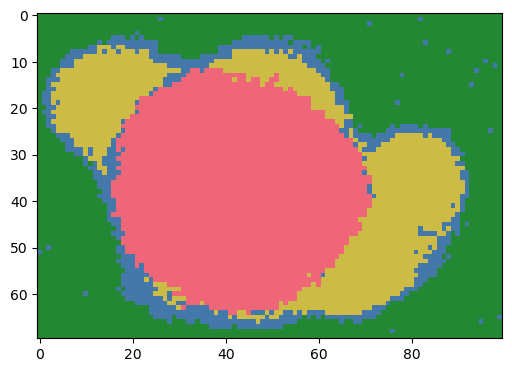

In [9]:
labels_map = estimator1.labels_.reshape((n_lines, n_cols))

plt.figure(figsize=(6, 6))
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44"]

plt.imshow(labels_map, cmap=ListedColormap(colors))

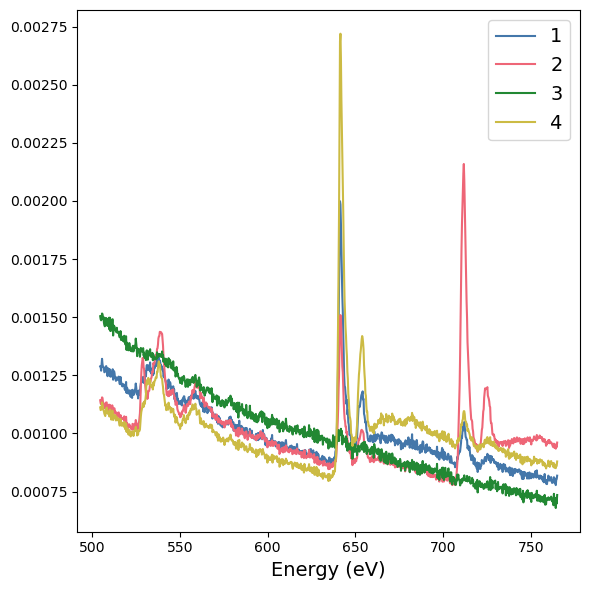

In [10]:
labels = ["1", "2", "3", "4"]
centroids = estimator1.cluster_centers_


# x axes energy values
x_values = np.arange(504.680, 504.680 + centroids.shape[1] * 0.263, 0.263)

# centroids spectra
plt.figure(figsize=(6, 6))
for i in range(centroids.shape[0]):
    plt.plot(x_values, centroids[i, :], label=labels[i], color=colors[i])

plt.xlabel('Energy (eV)', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

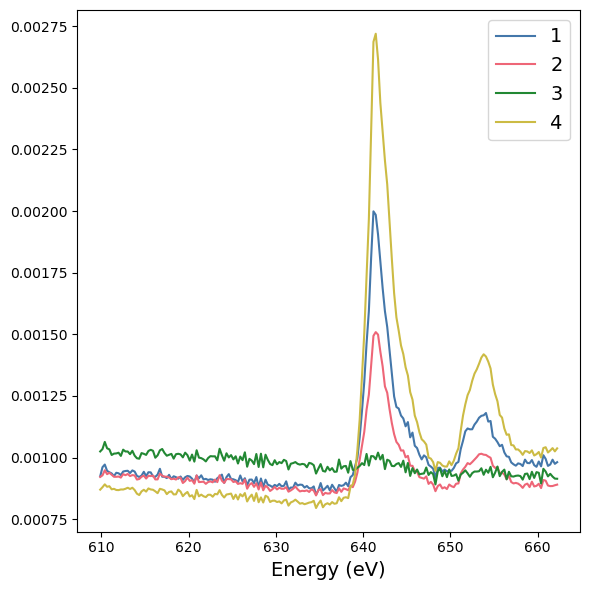

In [11]:
# zoom on the Mn-L edge
plt.figure(figsize=(6, 6))
for i in range(centroids.shape[0]):
    plt.plot(x_values[400:600], centroids[i, 400:600], label=labels[i], color=colors[i])

plt.xlabel('Energy (eV)', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

We obtain a cluster map that somehow resembles the HAADF image of the particle, along with centroids that seems to correspond to EELS spectra. However, assessing the quality of the clustering remains challenging. In this case, we evaluate it based on how well the centroids match reference spectra of known compounds present in the sample (MnO, Mn₃O₄, and Fe₃O₄).

Importantly, this example is used for demonstration purposes, and we can rely on the published results of the corresponding article to guide our interpretation. Several aspects — including the mismatch between centroids and reference spectra — lead us to conclude that the clustering result is not satisfactory.

It is also worth noting that the particle exhibits a core–shell geometry, which implies that the components are spatially mixed in some regions. Consequently, centroids cannot perfectly match the pure compounds. We will return to this issue in the next section on spectral unmixing, which is specifically designed to handle such cases.

To try and improve the clustering, we will reduce the dimensionality of the data using PCA (Principal Component Analysis).

This step is motivated by the so-called **curse of dimensionality**: there's plenty of space in high dimensions so most training instances are likely to be far away form each other and high-dimensional data sets are at risk of being very sparse and dissimilar in many ways. This makes it harder to find patterns or relationships in the data.

In [12]:
# We now will use clustering with dimensionality reduced data.  
# We load the data (cf Notebook 01)

HS_image_reduced_3D = np.load(r'C:\Users\brun\Documents\Donnees\AutumnSchool_AI_in_Electron_Microscopy2025\DataSets\MnOFeO_NP_coreLoss_reduced_70x100x7.npy')

In [13]:
# we check the dimensions
HS_image_reduced_3D.shape

(70, 100, 7)

In [14]:
n_components = 7 # value determined in Notebook 01

In [15]:
# we have to flatten the data
HS_image_reduced = HS_image_reduced_3D.reshape(-1, 7)

In [16]:
HS_image_reduced.shape

(7000, 7)

In [17]:
# Weight PCA components by the square root of their explained variance to balance their contribution before clustering.
# This avoids the first PCA component from dominating the clustering, and allows all components to contribute equally.
# we load a file
explained_var = np.load(r'C:\Users\brun\Documents\Donnees\AutumnSchool_AI_in_Electron_Microscopy2025\DataSets\MnOFeO_NP_coreLoss_variance_ratio.npy')

weights = np.sqrt(explained_var[:n_components])
HS_image_2 = HS_image_reduced / weights

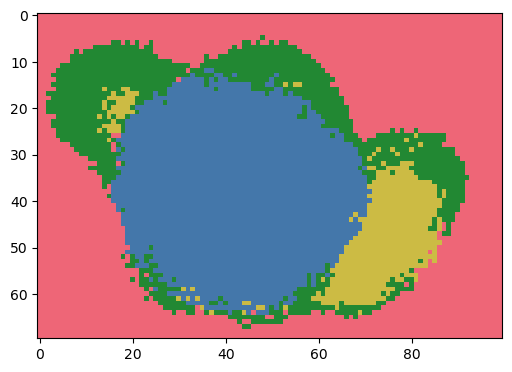

In [18]:
# we apply K-Means to the reduced data

n_clusters=4

estimator2 = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
estimator2.fit(HS_image_2)

# visualisation of the labels map

labels_map_2 = estimator2.labels_.reshape((n_lines, n_cols))

plt.figure(figsize=(6, 6))

colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44"]
colors_b = ["#4E79A7", "#F28E2B", "#59A14F", "#B07AA1"]

plt.imshow(labels_map_2, cmap=ListedColormap(colors))

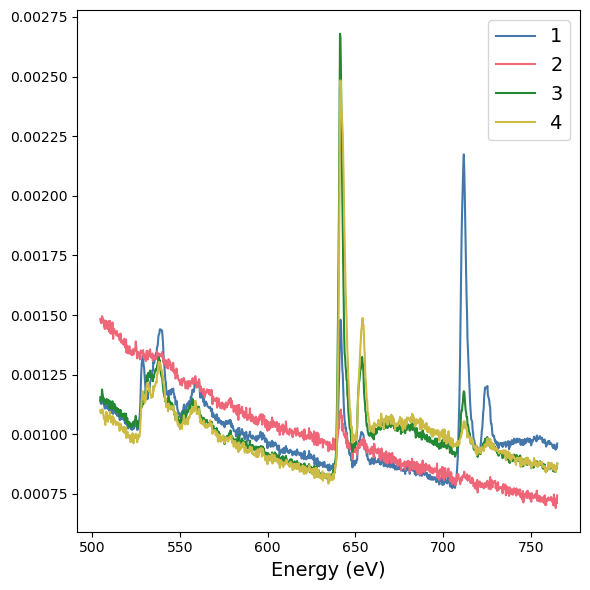

In [19]:
labels = ["1", "2", "3", "4"]
centroids = estimator2.cluster_centers_

#we compute the mean EELS spectrum per cluster directly from the original data

centroids_avg = np.zeros((n_clusters, HS_image.shape[1]))

for i in range(n_clusters):
    centroids_avg[i, :] = HS_image[estimator2.labels_ == i].mean(axis=0)

# Coordonnées en x
x_values = np.arange(504.680, 504.680 + centroids_avg.shape[1] * 0.263, 0.263)

# Tracer les spectres centroides
plt.figure(figsize=(6, 6))
for i in range(centroids_avg.shape[0]):
    plt.plot(x_values, centroids_avg[i, :], label=labels[i], color=colors[i])

plt.xlabel('Energy (eV)', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Conclusions  

- PCA + K-Means is a common and efficient pipeline for unsupervised classification.
- PCA reduces the dimensionality of the data while preserving its main variations.

- K-Means clusters the resulting components, assuming convex-shaped groups and equal variances.

- the average spectra per cluster remain interpretable.

We now explore a second strategy using DBSCAN or HDBSCAN for density-based clustering.

## 2. (H)DBSCAN  

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups together points that are densely packed, and identifies low-density points as outliers.
HDBSCAN is a hierarchical extension that automatically determines the number of clusters and handles varying densities more robustly.
These methods are particularly suited for irregularly shaped clusters and can discover non-convex structures that K-Means would miss.

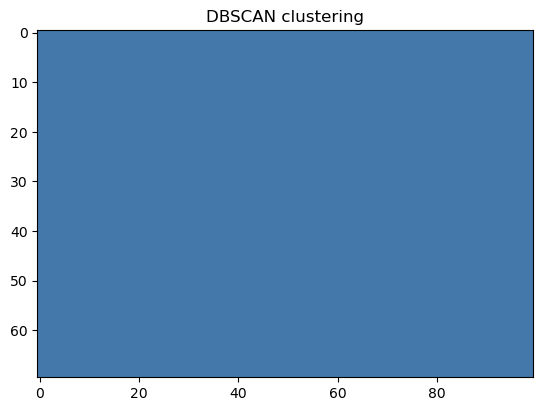

In [20]:
# Direct clustering on raw data

clusters = DBSCAN(eps=0.7, min_samples=10).fit_predict(HS_image)
cluster_map = clusters.reshape((n_lines, n_cols))

colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44"]

plt.imshow(cluster_map, cmap=ListedColormap(colors))
plt.title("DBSCAN clustering")
plt.show()

This typically fails due to the **curse of dimensionality**: in high-dimensional spaces, all points tend to appear far from one another, making it hard for density-based methods to detect structure.
As expected, DBSCAN here finds a single cluster.
We need dimensionality reduction.

### 2.1 UMAP + DBSCAN/HDBSCAN: first trial

In [21]:
# we use UMAP to reduce the dimensionality of the image
# we do a first trial with the default values for UMAP
umap_model1 = UMAP(
    n_neighbors=15,   # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    min_dist=0.1,    # default 0.1, The effective minimum distance between embedded points.
    metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
    n_components=2 , # default 2, The dimension of the space to embed into.
    spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
)
image_umap1 = umap_model1.fit_transform(HS_image)

C:\Users\brun\AppData\Local\miniconda3\envs\UMAP_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


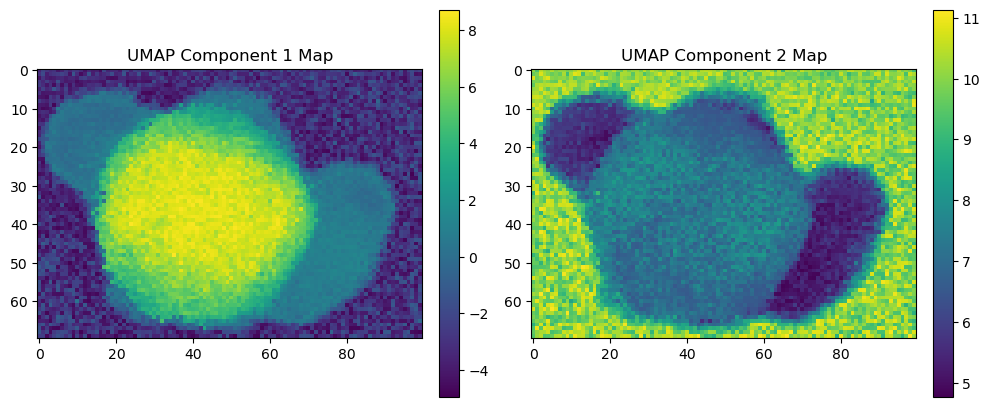

In [22]:
# we displaying  UMAP components as an image to visualize how this embedding dimension varies across the spatial map of the sample.

embedding_2d = image_umap1.reshape((n_lines, n_cols, 2))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Component 1
im1 = axes[0].imshow(embedding_2d[:, :, 0], cmap='viridis')
axes[0].set_title("UMAP Component 1 Map")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Component 2
im2 = axes[1].imshow(embedding_2d[:, :, 1], cmap='viridis')
axes[1].set_title("UMAP Component 2 Map")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

C:\Users\brun\AppData\Local\Temp\ipykernel_29516\2299831689.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(image_umap1[:, 0], image_umap1[:, 1], s=4, cmap='viridis', alpha=0.15)


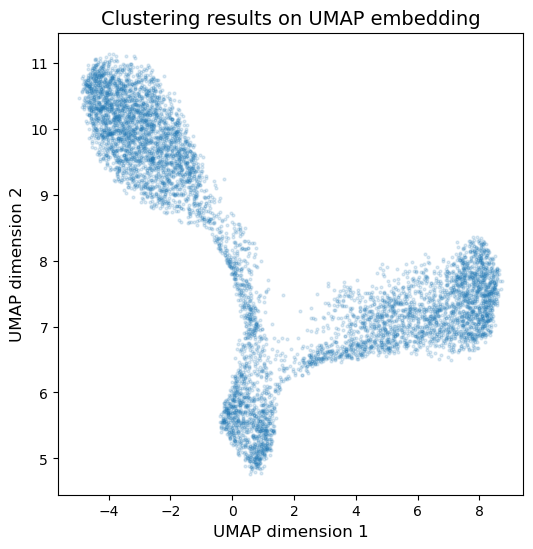

In [23]:
# Visualization of the UMAP embedding in 2D space.
# Each point represents a pixel from the original image, positioned according to its spectral similarity. 

plt.figure(figsize=(6,6))

plt.scatter(image_umap1[:, 0], image_umap1[:, 1], s=4, cmap='viridis', alpha=0.15)
plt.xlabel("UMAP dimension 1", fontsize=12)
plt.ylabel("UMAP dimension 2", fontsize=12)
plt.title("Clustering results on UMAP embedding", fontsize=14)
plt.show()

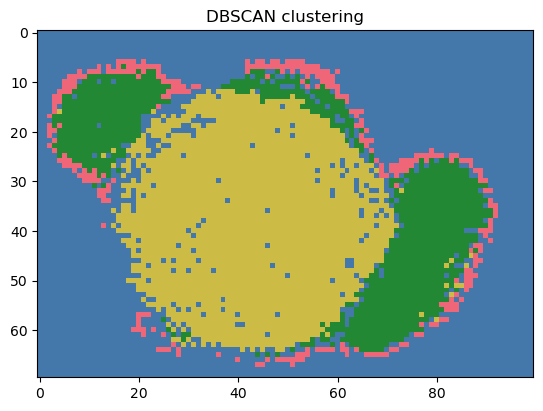

In [24]:
# let's perform clustering with DBSCAN
# we have to somewhat change the default values to get more than one clusters

clusters_11 = DBSCAN(eps=0.13, min_samples=16).fit_predict(image_umap1)
cluster_11_map = clusters_11.reshape((n_lines, n_cols))

plt.imshow(cluster_11_map, cmap=ListedColormap(colors))
plt.title("DBSCAN clustering")
plt.show()

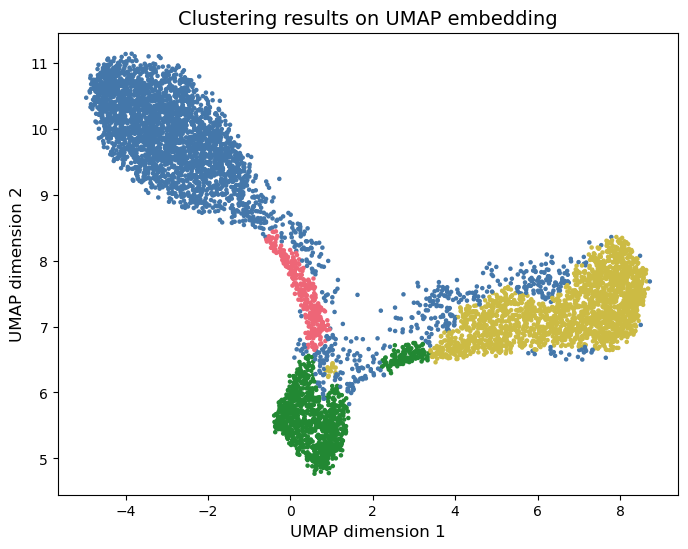

In [26]:
plt.figure(figsize=(8, 6))

# we labeled the pixels with the cluster index
scatter = plt.scatter(
    image_umap1[:, 0], image_umap1[:, 1],
    c=clusters_11,
    cmap=ListedColormap(colors),
    s=5
)

plt.xlabel("UMAP dimension 1", fontsize=12)
plt.ylabel("UMAP dimension 2", fontsize=12)
plt.title("Clustering results on UMAP embedding", fontsize=14)
plt.show()

C:\Users\brun\AppData\Local\miniconda3\envs\UMAP_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\UMAP_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


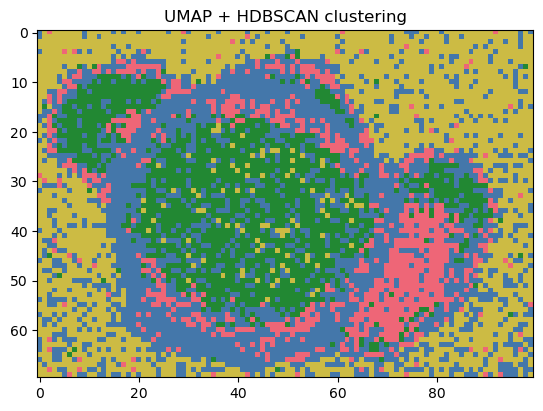

In [27]:
# clustering with HDBSCAN
n = image_umap1.shape[0]

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=max(8, int(0.003 * n)),  
    min_samples=2,                             
    cluster_selection_method="leaf",           
    cluster_selection_epsilon=0.05,            
    metric="euclidean",
    prediction_data=True,
    gen_min_span_tree=False
)

labels_12 = clusterer.fit_predict(image_umap1)

cluster_12_map = labels_12.reshape((n_lines, n_cols))

plt.imshow(cluster_12_map, cmap=ListedColormap(colors))
plt.title("UMAP + HDBSCAN clustering")
plt.show()

### 2.2 UMAP + DBSCAN/HDBSCAN: second trial

In [28]:
# we used ChatGPT to help with hyperparameters tuning
umap_model2 = UMAP(
    n_neighbors=15,   # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    min_dist=0.3,    # default 0.1, The effective minimum distance between embedded points.
    metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
    n_components=2 , # default 2, The dimension of the space to embed into.
    spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
)
image_umap2 = umap_model2.fit_transform(HS_image)

C:\Users\brun\AppData\Local\miniconda3\envs\UMAP_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [29]:
# then we apply clustering with DBSCAN ...

clusters_21 = DBSCAN(eps=0.15, min_samples=12).fit_predict(image_umap2)
cluster_21_map = clusters_21.reshape((n_lines, n_cols))

# ... and HDBSCAN

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=22,
    min_samples=18,
    cluster_selection_method='eom',
     
    prediction_data=True, 
    gen_min_span_tree=True,
    )

labels = clusterer.fit_predict(image_umap2)
cluster_22_map = labels.reshape((n_lines, n_cols))

C:\Users\brun\AppData\Local\miniconda3\envs\UMAP_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\UMAP_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


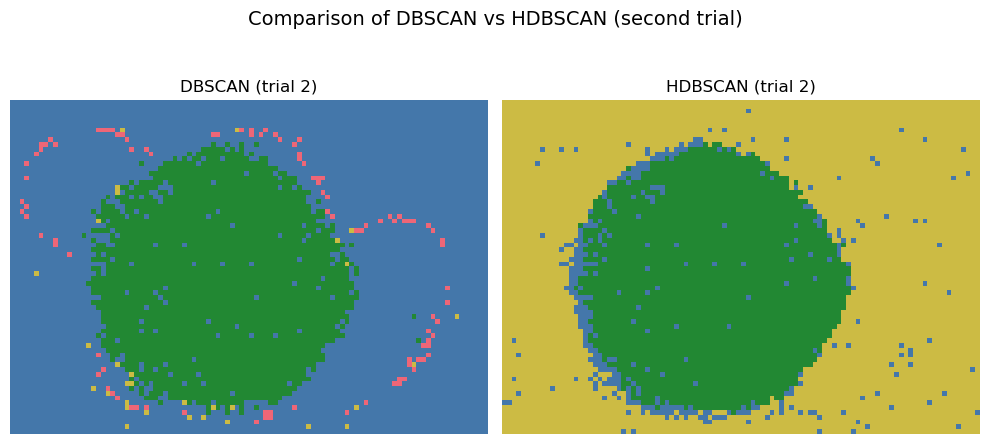

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(cluster_21_map, cmap=ListedColormap(colors))
axes[0].set_title("DBSCAN (trial 2)")
axes[0].axis("off")

axes[1].imshow(cluster_22_map, cmap=ListedColormap(colors))
axes[1].set_title("HDBSCAN (trial 2)")
axes[1].axis("off")

plt.suptitle("Comparison of DBSCAN vs HDBSCAN (second trial)", fontsize=14)
plt.tight_layout()
plt.show()


### 2.3 Conclusions  
Across several UMAP embeddings and parameter sets, **neither DBSCAN nor HDBSCAN produced stable or meaningful clusters**. 
This illustrates the **sensitivity of density-based clustering** and the **difficulty of applying it to EELS hyperspectral data**.  

Indeed, the pipeline proposed in the literature uses additional steps to achieve much better results.
In this simple demonstration, the goal is not to reproduce the perfect clustering from the paper, but to illustrate the method and highlight the challenges when working with real EELS data.

We will revisit these data in **Notebook 3**, exploring whether spectral unmixing methods might provide a more appropriate analysis strategy.